In [1]:
!pip install datasets==3.6.0 jiwer langid openai-whisper -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 59.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 80.5 MB/s eta 0:00:00


In [2]:
import os
import re
import torch
import jiwer
import langid
import numpy as np
import pandas as pd
from collections import Counter
from datasets import Audio
import whisper
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset_builder, Split, Audio, concatenate_datasets

In [3]:
# Explicit builder
builder = load_dataset_builder(
    "tobiolatunji/afrispeech-200",
    name="pidgin"
)

# Run dataset script
builder.download_and_prepare()

# Create dataset
pidgin_speech = builder.as_dataset()

pidgin_speech = pidgin_speech.cast_column("audio", Audio(sampling_rate=16_000))

train_ds = pidgin_speech[Split.TRAIN]
dev_ds   = pidgin_speech[Split.VALIDATION]
test_ds  = pidgin_speech[Split.TEST]

all_samples = concatenate_datasets([train_ds, dev_ds])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

afrispeech-200.py: 0.00B [00:00, ?B/s]

accent_stats.py: 0.00B [00:00, ?B/s]

The repository for tobiolatunji/afrispeech-200 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tobiolatunji/afrispeech-200.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


audio/pidgin/train/train_pidgin_0.tar.gz:   0%|          | 0.00/440M [00:00<?, ?B/s]

audio/pidgin/dev/dev_pidgin_0.tar.gz:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

audio/pidgin/test/test_pidgin_0.tar.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

transcripts/pidgin/train.csv:   0%|          | 0.00/156k [00:00<?, ?B/s]

transcripts/pidgin/dev.csv:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

transcripts/pidgin/test.csv:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 439it [00:00, 77885.85it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 26it [00:00, 75001.31it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 45it [00:00, 77832.45it/s]


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
whisper_base = whisper.load_model("small")

100%|████████████████████████████████████████| 461M/461M [00:02<00:00, 170MiB/s]


In [6]:
w2v_processor_base = Wav2Vec2Processor.from_pretrained(
    "jonatasgrosman/wav2vec2-large-xlsr-53-english"
)

w2v_model_base = Wav2Vec2ForCTC.from_pretrained(
    "jonatasgrosman/wav2vec2-large-xlsr-53-english"
).to(device)

w2v_model_base.eval()

preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

Whisper_DIR = "/content/drive/MyDrive/project/Whisper_Fair/Fair/"

whisper_processor = WhisperProcessor.from_pretrained(Whisper_DIR)
whisper_model = WhisperForConditionalGeneration.from_pretrained(
    Whisper_DIR,
    device_map="auto"
)
whisper_model.to(device)
whisper_model.eval()

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [9]:
WAV_DIR = "/content/drive/MyDrive/project/Bert_No_Fair/No_Fair/"

from transformers import Wav2Vec2BertProcessor

w2v_bert_processor = Wav2Vec2BertProcessor.from_pretrained(WAV_DIR)

from transformers import Wav2Vec2BertForCTC

w2v_bert_model  = Wav2Vec2BertForCTC.from_pretrained(WAV_DIR)
w2v_bert_model.to(device)
w2v_bert_model.eval()

Wav2Vec2BertForCTC(
  (wav2vec2_bert): Wav2Vec2BertModel(
    (feature_projection): Wav2Vec2BertFeatureProjection(
      (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=160, out_features=1024, bias=True)
      (dropout): Dropout(p=0.001, inplace=False)
    )
    (encoder): Wav2Vec2BertEncoder(
      (dropout): Dropout(p=0.01, inplace=False)
      (layers): ModuleList(
        (0-23): 24 x Wav2Vec2BertEncoderLayer(
          (ffn1_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (ffn1): Wav2Vec2BertFeedForward(
            (intermediate_dropout): Dropout(p=0.0, inplace=False)
            (intermediate_dense): Linear(in_features=1024, out_features=4096, bias=True)
            (intermediate_act_fn): SiLU()
            (output_dense): Linear(in_features=4096, out_features=1024, bias=True)
            (output_dropout): Dropout(p=0.01, inplace=False)
          )
          (self_attn_layer_norm): LayerNorm

In [10]:
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [11]:
def transcribe_whisper_base(audio_array):
    return normalize_text(
        whisper_base.transcribe(audio_array, fp16=False, language="en")["text"]
    )

In [12]:
def transcribe_whisper_ft(audio_arrays, max_new_tokens=225):
    inputs = whisper_processor(
        audio_arrays,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        pred_ids = whisper_model.generate(**inputs, max_new_tokens=max_new_tokens)

    texts = whisper_processor.batch_decode(pred_ids, skip_special_tokens=True)
    return [normalize_text(t) for t in texts]

In [13]:
def transcribe_wav2vec(audio_arrays, processor, model):
    inputs = processor(
        audio_arrays,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    pred_ids = torch.argmax(logits, dim=-1)
    texts = processor.batch_decode(pred_ids, skip_special_tokens=True)
    return [normalize_text(t) for t in texts]

In [15]:
import json

def load_medical_terms(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return {
        normalize_text(t)
        for t in data.keys()
        if len(t) > 3 and not t.isdigit()
    }

medical_terms = load_medical_terms("clinical_terms.json")

In [16]:
EN_CONF_THRESH = 0.70

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def is_english(token):
    lang, score = langid.classify(token)
    return lang == "en" and score >= EN_CONF_THRESH

def lexical_ratios(text):
    tokens = tokenize(text)
    if not tokens:
        return {"accent_strength": 0.0, "cs_strength": 0.0}

    eng = med = res = 0
    for t in tokens:
        if t in medical_terms:
            med += 1
        elif is_english(t):
            eng += 1
        else:
            res += 1

    total = eng + med + res
    return {
        "accent_strength": res / total,
        "cs_strength": min(eng / total, res / total)
    }

In [19]:
def build_base_df(ds):
    refs, audios, ratios = [], [], []

    for ex in ds:
        ref = normalize_text(ex["transcript"])
        refs.append(ref)
        audios.append(ex["audio"]["array"].astype(np.float32))
        ratios.append(lexical_ratios(ref))

    df = pd.DataFrame(ratios)
    df["reference"] = refs
    df["audio"] = audios

    df["accent_level"] = pd.cut(
        df["accent_strength"],
        [0, 0.2, 0.4, 1.0],
        labels=["Low", "Medium", "High"]
    )
    return df

In [21]:
from matplotlib import pyplot as plt

def evaluate_single_model(
    df,
    split_name,
    model_name,
    transcribe_fn,
    batch_size=8,
    plot=True
):
    preds = []

    audios = df["audio"].tolist()

    for i in range(0, len(audios), batch_size):
        batch = audios[i:i+batch_size]
        preds.extend(transcribe_fn(batch))

    df = df.copy()
    df[model_name] = preds

    # Utterance-level WER
    df[f"utt_wer_{model_name}"] = [
        jiwer.wer(r, h) if r else np.nan
        for r, h in zip(df["reference"], df[model_name])
    ]

    print(f"\n===== {split_name.upper()} | {model_name} =====")

    for lvl in df["accent_level"].dropna().unique():
        sub = df[df.accent_level == lvl]
        if len(sub) < 3:
            continue

        wer = jiwer.wer(
            sub["reference"].tolist(),
            sub[model_name].tolist()
        )
        cer = jiwer.cer(
            sub["reference"].tolist(),
            sub[model_name].tolist()
        )

        print(f" Accent {lvl}: WER={wer:.3f}, CER={cer:.3f}")

    if plot:
        plt.figure(figsize=(6,4))
        plt.scatter(
            df["accent_strength"],
            df[f"utt_wer_{model_name}"],
            alpha=0.4
        )
        plt.xlabel("Accent Strength (Residual Ratio)")
        plt.ylabel(f"Utterance WER ({model_name})")
        plt.title(f"{split_name}: WER vs Accent Strength")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df

In [22]:
def whisper_base_batch(batch):
    return [transcribe_whisper_base(a) for a in batch]

In [23]:
def whisper_ft_batch(batch):
    return transcribe_whisper_ft(batch)

In [24]:
def w2v_base_batch(batch):
    return transcribe_wav2vec(
        batch, w2v_processor_base, w2v_model_base
    )

In [26]:
def w2v_bert_batch(batch):
    return transcribe_wav2vec(
        batch, w2v_bert_processor, w2v_bert_model
    )


===== TRAIN | whisper_base =====
 Accent Medium: WER=0.404, CER=0.218
 Accent Low: WER=0.337, CER=0.193


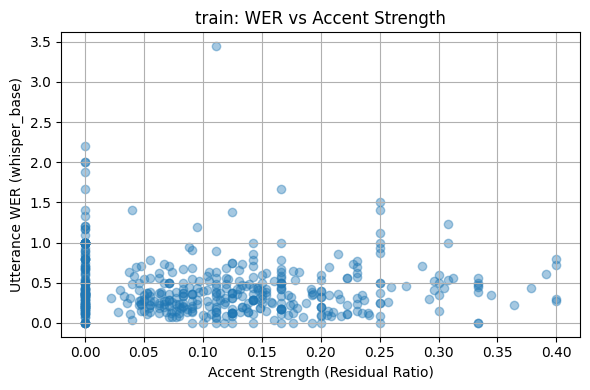

In [28]:
train_base = build_base_df(all_samples)

# Evaluate models ONE BY ONE
train_whisper_base = evaluate_single_model(
    train_base,
    "train",
    "whisper_base",
    whisper_base_batch
)


===== TRAIN | whisper_ft =====
 Accent Medium: WER=0.068, CER=0.038
 Accent Low: WER=0.091, CER=0.049


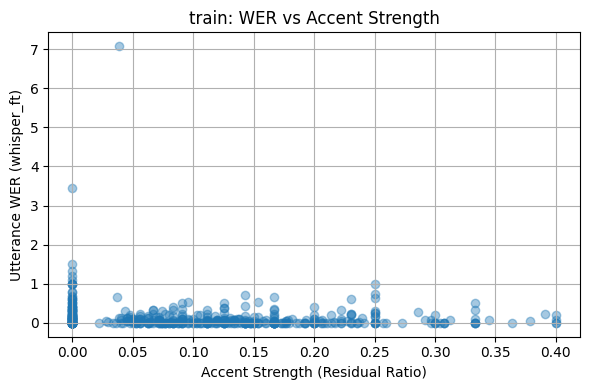

In [29]:
train_whisper_ft = evaluate_single_model(
    train_base,
    "train",
    "whisper_ft",
    whisper_ft_batch
)


===== TRAIN | wav2vec2_base =====
 Accent Medium: WER=0.617, CER=0.303
 Accent Low: WER=0.573, CER=0.281


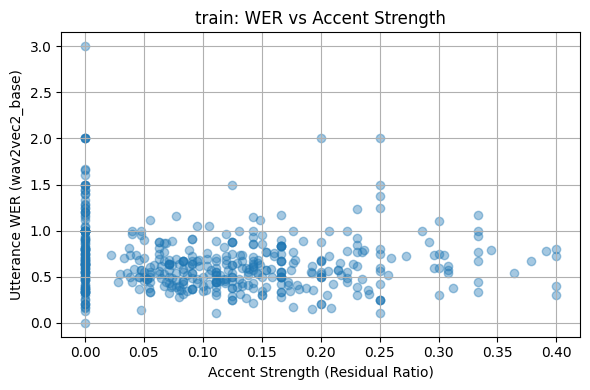

In [30]:
train_w2v_base = evaluate_single_model(
    train_base,
    "train",
    "wav2vec2_base",
    w2v_base_batch
)


===== TRAIN | wav2vec2_bert =====
 Accent Medium: WER=0.132, CER=0.037
 Accent Low: WER=0.142, CER=0.035


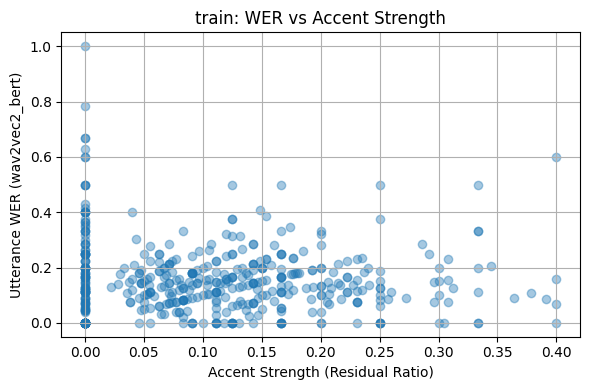

In [31]:
train_w2v_bert = evaluate_single_model(
    train_base,
    "train",
    "wav2vec2_bert",
    w2v_bert_batch
)


===== TEST | whisper_base =====
 Accent Low: WER=0.316, CER=0.188
 Accent Medium: WER=0.477, CER=0.239


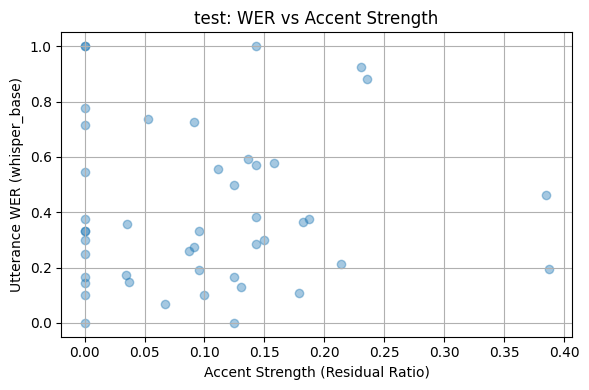

In [32]:
test_base = build_base_df(test_ds)

# Evaluate models ONE BY ONE
test_whisper_base = evaluate_single_model(
    test_base,
    "test",
    "whisper_base",
    whisper_base_batch
)


===== TEST | whisper_ft =====
 Accent Low: WER=0.206, CER=0.119
 Accent Medium: WER=0.216, CER=0.101


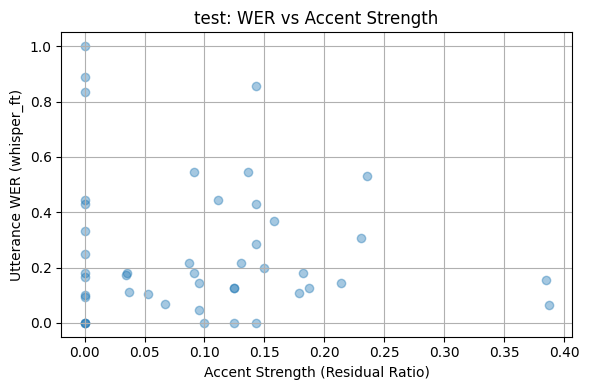

In [33]:
test_whisper_ft = evaluate_single_model(
    test_base,
    "test",
    "whisper_ft",
    whisper_ft_batch
)


===== TEST | wav2vec2_base =====
 Accent Low: WER=0.502, CER=0.238
 Accent Medium: WER=0.591, CER=0.286


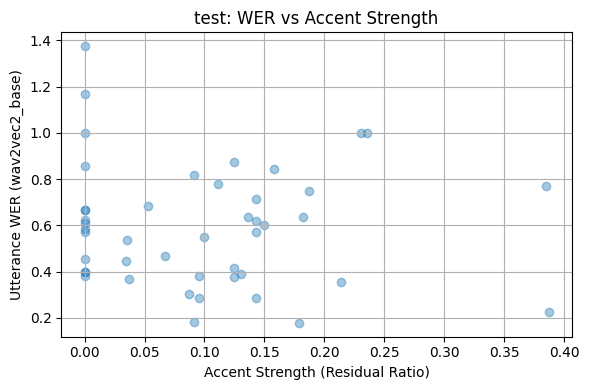

In [34]:
test_w2v_base = evaluate_single_model(
    test_base,
    "test",
    "wav2vec2_base",
    w2v_base_batch
)


===== TEST | wav2vec2_bert =====
 Accent Low: WER=0.362, CER=0.131
 Accent Medium: WER=0.455, CER=0.173


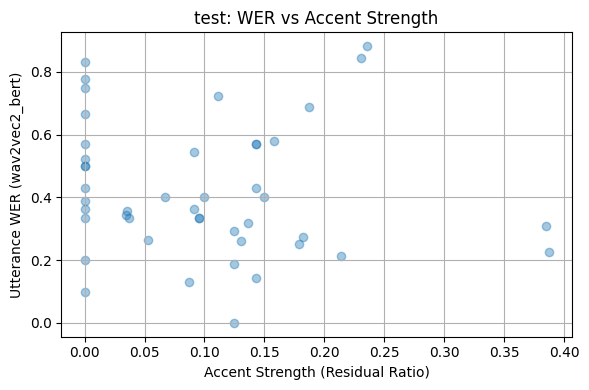

In [35]:
test_w2v_bert = evaluate_single_model(
    test_base,
    "test",
    "wav2vec2_bert",
    w2v_bert_batch
)